MODELING A TRANSFORMER BASED ON EDGEVIT 


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [55]:
class EfficientAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(EfficientAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.o_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv_proj(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        
        attn_weights = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        output = self.o_proj(attn_output)
        return output

class TinyTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1, attention_dropout=0.1):
        super(TinyTransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = EfficientAttention(embed_dim, num_heads, attention_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TinyTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=100, embed_dim=64, depth=6, num_heads=4, mlp_ratio=4.0):
        super(TinyTransformer, self).__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)
        
        self.blocks = nn.ModuleList([
            TinyTransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)
        
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# Initialize model
model = TinyTransformer()


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Training loop
def train(model, trainloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    return running_loss / len(trainloader)

# Evaluation loop
def evaluate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(testloader), accuracy

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, scheduler, device)
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


KeyboardInterrupt: 

In [47]:
model_save_path = 'models/tiny_transformer_cifar100.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to models/tiny_transformer_cifar100.pth


Test Accuracy: 0.4481
Classification Report:
               precision    recall  f1-score   support

        apple       0.81      0.60      0.69       100
aquarium_fish       0.42      0.58      0.49       100
         baby       0.50      0.27      0.35       100
         bear       0.28      0.20      0.23       100
       beaver       0.50      0.11      0.18       100
          bed       0.34      0.35      0.34       100
          bee       0.48      0.59      0.53       100
       beetle       0.47      0.43      0.45       100
      bicycle       0.59      0.43      0.50       100
       bottle       0.47      0.56      0.51       100
         bowl       0.22      0.32      0.26       100
          boy       0.36      0.39      0.37       100
       bridge       0.49      0.54      0.51       100
          bus       0.33      0.35      0.34       100
    butterfly       0.20      0.45      0.28       100
        camel       0.39      0.45      0.42       100
          can      

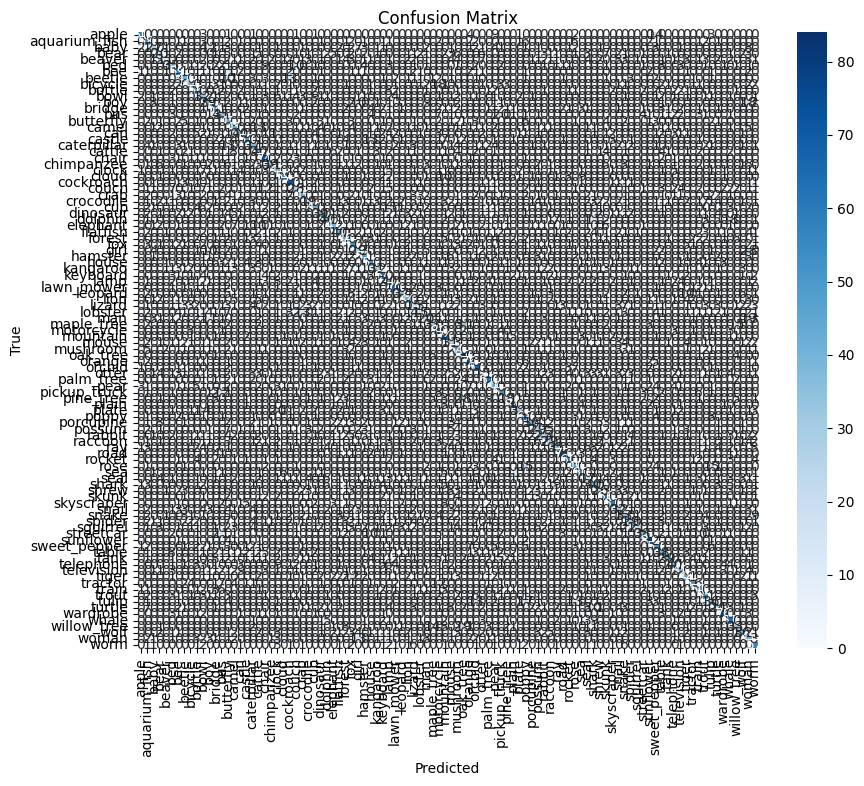

In [58]:
model.load_state_dict(torch.load('models/tiny_transformer_cifar100.pth'))
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200] - Train Loss: 4.0458, Test Loss: 3.7202, Test Accuracy: 12.61%
Epoch [2/200] - Train Loss: 3.5718, Test Loss: 3.3952, Test Accuracy: 18.05%
Epoch [3/200] - Train Loss: 3.2970, Test Loss: 3.1576, Test Accuracy: 22.42%
Epoch [4/200] - Train Loss: 3.1102, Test Loss: 3.0254, Test Accuracy: 25.05%
Epoch [5/200] - Train Loss: 2.9764, Test Loss: 2.8824, Test Accuracy: 27.56%
Epoch [6/200] - Train Loss: 2.8546, Test Loss: 2.7789, Test Accuracy: 29.25%
Epoch [7/200] - Train Loss: 2.7408, Test Loss: 2.6827, Test Accuracy: 31.64%
Epoch [8/200] - Train Loss: 2.6532, Test Loss: 2.6069, Test Accuracy: 33.20%
Epoch [9/200] - Train Loss: 2.5655, Test Loss: 2.5369, Test Accuracy: 34.69%
Epoch [10/200] - Train Loss: 2.4883, Test Loss: 2.4513, Test Accuracy: 36.39%
Epoch [11/200] - Train Loss: 2.4152, Test Loss: 2.4242, Test Accuracy: 37.18%
Epoch [12/200] - Train Loss: 2.3369, Test Loss: 2.3249, Test Accuracy: 38.7

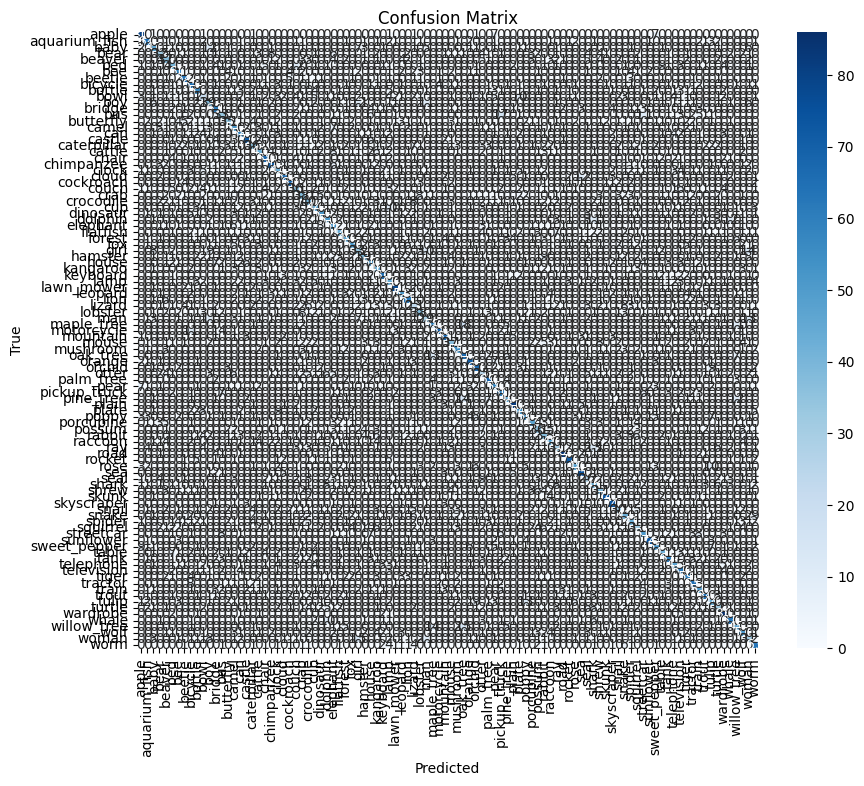

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# EfficientAttention module
class EfficientAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(EfficientAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.o_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv_proj(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        
        attn_weights = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        output = self.o_proj(attn_output)
        return output

# TinyTransformerBlock module
class TinyTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1, attention_dropout=0.1):
        super(TinyTransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = EfficientAttention(embed_dim, num_heads, attention_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# TinyTransformer module
class TinyTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=100, embed_dim=64, depth=6, num_heads=4, mlp_ratio=4.0):
        super(TinyTransformer, self).__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)
        
        self.blocks = nn.ModuleList([
            TinyTransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)
        
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# model
model = TinyTransformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Training 
def train(model, trainloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    return running_loss / len(trainloader)

# Evaluation 
def evaluate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(testloader), accuracy

# Training the model
num_epochs = 200
best_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, scheduler, device)
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    
    # Save best 
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'reworked_tiny_transformer_cifar100.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Load best 
model.load_state_dict(torch.load('reworked_tiny_transformer_cifar100.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

#  accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [83]:
model.load_state_dict(torch.load('reworked_tiny_transformer_cifar100.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

#  accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Train Accuracy: {accuracy:.4f}')

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

RuntimeError: Error(s) in loading state_dict for EfficientFormerForImageClassification:
	Missing key(s) in state_dict: "efficientformer.patch_embed.convolution1.weight", "efficientformer.patch_embed.convolution1.bias", "efficientformer.patch_embed.batchnorm_before.weight", "efficientformer.patch_embed.batchnorm_before.bias", "efficientformer.patch_embed.batchnorm_before.running_mean", "efficientformer.patch_embed.batchnorm_before.running_var", "efficientformer.patch_embed.convolution2.weight", "efficientformer.patch_embed.convolution2.bias", "efficientformer.patch_embed.batchnorm_after.weight", "efficientformer.patch_embed.batchnorm_after.bias", "efficientformer.patch_embed.batchnorm_after.running_mean", "efficientformer.patch_embed.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.layer_scale_1", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.layer_scale_2", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.0.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.layer_scale_1", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.layer_scale_2", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.1.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.layer_scale_1", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.layer_scale_2", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.0.meta4D_layers.blocks.2.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.1.projection.weight", "efficientformer.encoder.intermediate_stages.1.projection.bias", "efficientformer.encoder.intermediate_stages.1.norm.weight", "efficientformer.encoder.intermediate_stages.1.norm.bias", "efficientformer.encoder.intermediate_stages.1.norm.running_mean", "efficientformer.encoder.intermediate_stages.1.norm.running_var", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.layer_scale_1", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.layer_scale_2", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.0.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.layer_scale_1", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.layer_scale_2", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.2.meta4D_layers.blocks.1.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.3.projection.weight", "efficientformer.encoder.intermediate_stages.3.projection.bias", "efficientformer.encoder.intermediate_stages.3.norm.weight", "efficientformer.encoder.intermediate_stages.3.norm.bias", "efficientformer.encoder.intermediate_stages.3.norm.running_mean", "efficientformer.encoder.intermediate_stages.3.norm.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.0.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.1.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.2.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.3.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.4.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.layer_scale_1", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.layer_scale_2", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.convolution1.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.convolution1.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.convolution2.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.convolution2.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_before.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_before.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_before.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_before.running_var", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_after.weight", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_after.bias", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_after.running_mean", "efficientformer.encoder.intermediate_stages.4.meta4D_layers.blocks.5.mlp.batchnorm_after.running_var", "efficientformer.encoder.intermediate_stages.5.projection.weight", "efficientformer.encoder.intermediate_stages.5.projection.bias", "efficientformer.encoder.intermediate_stages.5.norm.weight", "efficientformer.encoder.intermediate_stages.5.norm.bias", "efficientformer.encoder.intermediate_stages.5.norm.running_mean", "efficientformer.encoder.intermediate_stages.5.norm.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.layer_scale_1", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.layer_scale_2", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.convolution1.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.convolution1.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.convolution2.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.convolution2.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_before.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_before.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_before.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_before.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_after.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_after.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_after.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.0.mlp.batchnorm_after.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.layer_scale_1", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.layer_scale_2", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.convolution1.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.convolution1.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.convolution2.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.convolution2.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_before.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_before.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_before.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_before.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_after.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_after.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_after.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.1.mlp.batchnorm_after.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.layer_scale_1", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.layer_scale_2", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.convolution1.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.convolution1.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.convolution2.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.convolution2.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_before.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_before.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_before.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_before.running_var", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_after.weight", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_after.bias", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_after.running_mean", "efficientformer.encoder.last_stage.meta4D_layers.blocks.2.mlp.batchnorm_after.running_var", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layer_scale_1", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layer_scale_2", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.attention_biases", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.attention_bias_idxs", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.qkv.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.qkv.bias", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.projection.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.token_mixer.projection.bias", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layernorm1.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layernorm1.bias", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layernorm2.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.layernorm2.bias", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.mlp.linear_in.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.mlp.linear_in.bias", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.mlp.linear_out.weight", "efficientformer.encoder.last_stage.meta3D_layers.blocks.0.mlp.linear_out.bias", "efficientformer.layernorm.weight", "efficientformer.layernorm.bias", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "cls_token", "pos_embed", "patch_embed.weight", "patch_embed.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.qkv_proj.weight", "blocks.0.attn.o_proj.weight", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.0.mlp.0.weight", "blocks.0.mlp.0.bias", "blocks.0.mlp.2.weight", "blocks.0.mlp.2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.qkv_proj.weight", "blocks.1.attn.o_proj.weight", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.1.mlp.0.weight", "blocks.1.mlp.0.bias", "blocks.1.mlp.2.weight", "blocks.1.mlp.2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.qkv_proj.weight", "blocks.2.attn.o_proj.weight", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.2.mlp.0.weight", "blocks.2.mlp.0.bias", "blocks.2.mlp.2.weight", "blocks.2.mlp.2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.qkv_proj.weight", "blocks.3.attn.o_proj.weight", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.3.mlp.0.weight", "blocks.3.mlp.0.bias", "blocks.3.mlp.2.weight", "blocks.3.mlp.2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.qkv_proj.weight", "blocks.4.attn.o_proj.weight", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.4.mlp.0.weight", "blocks.4.mlp.0.bias", "blocks.4.mlp.2.weight", "blocks.4.mlp.2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.qkv_proj.weight", "blocks.5.attn.o_proj.weight", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.5.mlp.0.weight", "blocks.5.mlp.0.bias", "blocks.5.mlp.2.weight", "blocks.5.mlp.2.bias", "norm.weight", "norm.bias", "head.weight", "head.bias". 

first attempt at finetuning

In [66]:
# Load the best model
model.load_state_dict(torch.load('reworked_tiny_transformer_cifar100.pth'))

# Update optimizer with a lower learning rate for fine-tuning
fine_tune_lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=fine_tune_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # Shorter annealing period for fine-tuning

# Fine-tuning the model
fine_tune_epochs = 100
best_accuracy = 0.0  # Reset best accuracy for fine-tuning

for epoch in range(fine_tune_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, scheduler, device)
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    
    # Save best model during fine-tuning
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'initial_fine_tuned_tiny_transformer_cifar100.pth')
    
    print(f"Epoch [{epoch+1}/{fine_tune_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Load the fine-tuned model
model.load_state_dict(torch.load('initial_fine_tuned_tiny_transformer_cifar100.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy after fine-tuning: {accuracy:.4f}')

# Classification report
print("Classification Report after fine-tuning:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix after fine-tuning')
plt.show()


Epoch [1/100] - Train Loss: 0.4429, Test Loss: 2.3903, Test Accuracy: 52.63%
Epoch [2/100] - Train Loss: 0.4426, Test Loss: 2.4149, Test Accuracy: 52.43%
Epoch [3/100] - Train Loss: 0.4506, Test Loss: 2.4272, Test Accuracy: 52.18%
Epoch [4/100] - Train Loss: 0.4462, Test Loss: 2.4229, Test Accuracy: 52.22%
Epoch [5/100] - Train Loss: 0.4482, Test Loss: 2.4080, Test Accuracy: 52.28%
Epoch [6/100] - Train Loss: 0.4463, Test Loss: 2.4317, Test Accuracy: 51.90%
Epoch [7/100] - Train Loss: 0.4427, Test Loss: 2.4320, Test Accuracy: 52.25%
Epoch [8/100] - Train Loss: 0.4482, Test Loss: 2.4177, Test Accuracy: 51.88%
Epoch [9/100] - Train Loss: 0.4460, Test Loss: 2.4207, Test Accuracy: 52.29%
Epoch [10/100] - Train Loss: 0.4409, Test Loss: 2.4232, Test Accuracy: 52.05%
Epoch [11/100] - Train Loss: 0.4378, Test Loss: 2.4289, Test Accuracy: 52.47%
Epoch [12/100] - Train Loss: 0.4443, Test Loss: 2.4098, Test Accuracy: 52.61%
Epoch [13/100] - Train Loss: 0.4472, Test Loss: 2.4421, Test Accuracy: 52

KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified


  1%|          | 1/100 [00:30<50:40, 30.71s/it]

Epoch [1/100] - Train Loss: 2.6552, Test Loss: 2.7499, Test Accuracy: 35.62%


  2%|▏         | 2/100 [01:01<50:01, 30.62s/it]

Epoch [2/100] - Train Loss: 2.2641, Test Loss: 2.5364, Test Accuracy: 38.40%


  3%|▎         | 3/100 [01:31<49:23, 30.56s/it]

Epoch [3/100] - Train Loss: 2.2158, Test Loss: 2.4918, Test Accuracy: 38.63%


  4%|▍         | 4/100 [02:01<48:40, 30.42s/it]

Epoch [4/100] - Train Loss: 2.1727, Test Loss: 2.4586, Test Accuracy: 39.30%


  5%|▌         | 5/100 [02:32<48:19, 30.52s/it]

Epoch [5/100] - Train Loss: 2.1631, Test Loss: 2.4625, Test Accuracy: 39.98%


  6%|▌         | 6/100 [03:03<47:49, 30.53s/it]

Epoch [6/100] - Train Loss: 2.1433, Test Loss: 2.3697, Test Accuracy: 39.89%


  7%|▋         | 7/100 [03:33<47:12, 30.45s/it]

Epoch [7/100] - Train Loss: 2.1346, Test Loss: 2.3725, Test Accuracy: 40.53%


  8%|▊         | 8/100 [04:03<46:33, 30.37s/it]

Epoch [8/100] - Train Loss: 2.1298, Test Loss: 2.3962, Test Accuracy: 39.61%


  9%|▉         | 9/100 [04:32<45:28, 29.98s/it]

Epoch [9/100] - Train Loss: 2.1232, Test Loss: 2.3933, Test Accuracy: 39.98%


 10%|█         | 10/100 [05:02<44:49, 29.89s/it]

Epoch [10/100] - Train Loss: 2.1160, Test Loss: 2.3660, Test Accuracy: 39.23%


 11%|█         | 11/100 [05:33<44:46, 30.19s/it]

Epoch [11/100] - Train Loss: 2.1041, Test Loss: 2.3554, Test Accuracy: 40.18%


 12%|█▏        | 12/100 [06:02<43:54, 29.93s/it]

Epoch [12/100] - Train Loss: 2.1140, Test Loss: 2.3182, Test Accuracy: 41.10%


 13%|█▎        | 13/100 [06:32<43:18, 29.87s/it]

Epoch [13/100] - Train Loss: 2.0938, Test Loss: 2.3761, Test Accuracy: 40.09%


 14%|█▍        | 14/100 [07:02<42:53, 29.92s/it]

Epoch [14/100] - Train Loss: 2.0899, Test Loss: 2.3267, Test Accuracy: 41.50%


 15%|█▌        | 15/100 [07:32<42:33, 30.04s/it]

Epoch [15/100] - Train Loss: 2.0797, Test Loss: 2.3045, Test Accuracy: 41.20%


 16%|█▌        | 16/100 [08:03<42:14, 30.17s/it]

Epoch [16/100] - Train Loss: 2.0882, Test Loss: 2.3305, Test Accuracy: 40.84%


 17%|█▋        | 17/100 [08:32<41:32, 30.03s/it]

Epoch [17/100] - Train Loss: 2.0749, Test Loss: 2.2943, Test Accuracy: 41.42%


 18%|█▊        | 18/100 [09:02<40:59, 30.00s/it]

Epoch [18/100] - Train Loss: 2.0881, Test Loss: 2.2959, Test Accuracy: 41.84%


 19%|█▉        | 19/100 [09:33<40:37, 30.09s/it]

Epoch [19/100] - Train Loss: 2.0749, Test Loss: 2.2871, Test Accuracy: 41.46%


 20%|██        | 20/100 [10:03<40:08, 30.11s/it]

Epoch [20/100] - Train Loss: 2.0652, Test Loss: 2.2671, Test Accuracy: 41.89%


 21%|██        | 21/100 [10:34<39:53, 30.30s/it]

Epoch [21/100] - Train Loss: 2.0770, Test Loss: 2.2361, Test Accuracy: 42.38%


 22%|██▏       | 22/100 [11:04<39:24, 30.31s/it]

Epoch [22/100] - Train Loss: 2.0663, Test Loss: 2.2521, Test Accuracy: 42.22%


 23%|██▎       | 23/100 [11:34<38:40, 30.13s/it]

Epoch [23/100] - Train Loss: 2.0582, Test Loss: 2.2284, Test Accuracy: 42.90%


 24%|██▍       | 24/100 [12:03<38:00, 30.01s/it]

Epoch [24/100] - Train Loss: 2.0516, Test Loss: 2.2237, Test Accuracy: 42.48%


 25%|██▌       | 25/100 [12:33<37:29, 29.99s/it]

Epoch [25/100] - Train Loss: 2.0495, Test Loss: 2.2517, Test Accuracy: 42.84%


 26%|██▌       | 26/100 [13:03<36:44, 29.79s/it]

Epoch [26/100] - Train Loss: 2.0402, Test Loss: 2.2548, Test Accuracy: 42.29%


 27%|██▋       | 27/100 [13:32<36:04, 29.64s/it]

Epoch [27/100] - Train Loss: 2.0348, Test Loss: 2.2136, Test Accuracy: 42.87%


 28%|██▊       | 28/100 [14:01<35:30, 29.59s/it]

Epoch [28/100] - Train Loss: 2.0369, Test Loss: 2.2231, Test Accuracy: 42.83%


 29%|██▉       | 29/100 [14:32<35:12, 29.76s/it]

Epoch [29/100] - Train Loss: 2.0359, Test Loss: 2.2131, Test Accuracy: 42.74%


 30%|███       | 30/100 [15:02<34:46, 29.81s/it]

Epoch [30/100] - Train Loss: 2.0415, Test Loss: 2.2241, Test Accuracy: 43.55%


 31%|███       | 31/100 [15:32<34:29, 29.99s/it]

Epoch [31/100] - Train Loss: 2.0207, Test Loss: 2.2221, Test Accuracy: 42.81%


 32%|███▏      | 32/100 [16:02<33:51, 29.87s/it]

Epoch [32/100] - Train Loss: 2.0224, Test Loss: 2.2260, Test Accuracy: 43.00%


 33%|███▎      | 33/100 [16:31<33:21, 29.87s/it]

Epoch [33/100] - Train Loss: 2.0058, Test Loss: 2.2059, Test Accuracy: 43.11%


 34%|███▍      | 34/100 [17:01<32:47, 29.81s/it]

Epoch [34/100] - Train Loss: 2.0147, Test Loss: 2.2020, Test Accuracy: 43.12%


 35%|███▌      | 35/100 [17:32<32:30, 30.01s/it]

Epoch [35/100] - Train Loss: 2.0000, Test Loss: 2.2251, Test Accuracy: 42.78%


 36%|███▌      | 36/100 [18:02<32:05, 30.09s/it]

Epoch [36/100] - Train Loss: 2.0089, Test Loss: 2.2120, Test Accuracy: 43.15%


 37%|███▋      | 37/100 [18:32<31:29, 29.99s/it]

Epoch [37/100] - Train Loss: 2.0099, Test Loss: 2.2252, Test Accuracy: 43.30%


 38%|███▊      | 38/100 [19:02<31:02, 30.05s/it]

Epoch [38/100] - Train Loss: 1.9962, Test Loss: 2.2470, Test Accuracy: 42.12%


 39%|███▉      | 39/100 [19:33<30:46, 30.26s/it]

Epoch [39/100] - Train Loss: 1.9853, Test Loss: 2.2001, Test Accuracy: 43.11%


 40%|████      | 40/100 [20:03<30:11, 30.19s/it]

Epoch [40/100] - Train Loss: 1.9850, Test Loss: 2.1941, Test Accuracy: 43.76%


 41%|████      | 41/100 [20:33<29:49, 30.32s/it]

Epoch [41/100] - Train Loss: 1.9865, Test Loss: 2.1656, Test Accuracy: 44.39%


 42%|████▏     | 42/100 [21:03<29:05, 30.09s/it]

Epoch [42/100] - Train Loss: 1.9795, Test Loss: 2.1945, Test Accuracy: 43.55%


 43%|████▎     | 43/100 [21:33<28:38, 30.15s/it]

Epoch [43/100] - Train Loss: 1.9762, Test Loss: 2.1754, Test Accuracy: 44.08%


 44%|████▍     | 44/100 [22:03<28:06, 30.11s/it]

Epoch [44/100] - Train Loss: 1.9757, Test Loss: 2.1410, Test Accuracy: 44.29%


 45%|████▌     | 45/100 [22:32<27:24, 29.91s/it]

Epoch [45/100] - Train Loss: 1.9687, Test Loss: 2.1557, Test Accuracy: 44.11%


 46%|████▌     | 46/100 [23:03<27:02, 30.05s/it]

Epoch [46/100] - Train Loss: 1.9598, Test Loss: 2.1492, Test Accuracy: 44.55%


 47%|████▋     | 47/100 [23:33<26:33, 30.06s/it]

Epoch [47/100] - Train Loss: 1.9647, Test Loss: 2.1655, Test Accuracy: 44.47%


 48%|████▊     | 48/100 [24:03<26:07, 30.14s/it]

Epoch [48/100] - Train Loss: 1.9537, Test Loss: 2.1259, Test Accuracy: 45.09%


 49%|████▉     | 49/100 [24:34<25:45, 30.30s/it]

Epoch [49/100] - Train Loss: 1.9515, Test Loss: 2.1927, Test Accuracy: 43.81%


 50%|█████     | 50/100 [25:05<25:21, 30.43s/it]

Epoch [50/100] - Train Loss: 1.9471, Test Loss: 2.1377, Test Accuracy: 45.05%


 51%|█████     | 51/100 [25:35<24:48, 30.37s/it]

Epoch [51/100] - Train Loss: 1.9540, Test Loss: 2.1748, Test Accuracy: 44.01%


 52%|█████▏    | 52/100 [26:05<24:20, 30.44s/it]

Epoch [52/100] - Train Loss: 1.9367, Test Loss: 2.1567, Test Accuracy: 43.86%


 53%|█████▎    | 53/100 [26:36<23:53, 30.51s/it]

Epoch [53/100] - Train Loss: 1.9330, Test Loss: 2.1511, Test Accuracy: 44.33%


 54%|█████▍    | 54/100 [27:06<23:20, 30.44s/it]

Epoch [54/100] - Train Loss: 1.9301, Test Loss: 2.1338, Test Accuracy: 44.04%


 55%|█████▌    | 55/100 [27:37<22:49, 30.43s/it]

Epoch [55/100] - Train Loss: 1.9287, Test Loss: 2.1102, Test Accuracy: 44.94%


 56%|█████▌    | 56/100 [28:08<22:22, 30.52s/it]

Epoch [56/100] - Train Loss: 1.9160, Test Loss: 2.1407, Test Accuracy: 44.91%


 57%|█████▋    | 57/100 [28:38<21:55, 30.59s/it]

Epoch [57/100] - Train Loss: 1.9224, Test Loss: 2.2007, Test Accuracy: 43.21%


 58%|█████▊    | 58/100 [29:09<21:27, 30.67s/it]

Epoch [58/100] - Train Loss: 1.9156, Test Loss: 2.1218, Test Accuracy: 45.48%


 59%|█████▉    | 59/100 [29:40<20:58, 30.71s/it]

Epoch [59/100] - Train Loss: 1.9085, Test Loss: 2.1279, Test Accuracy: 45.35%


 60%|██████    | 60/100 [30:10<20:24, 30.61s/it]

Epoch [60/100] - Train Loss: 1.9048, Test Loss: 2.1080, Test Accuracy: 45.44%


 61%|██████    | 61/100 [30:41<19:56, 30.67s/it]

Epoch [61/100] - Train Loss: 1.9024, Test Loss: 2.1428, Test Accuracy: 44.64%


 62%|██████▏   | 62/100 [31:11<19:18, 30.50s/it]

Epoch [62/100] - Train Loss: 1.8969, Test Loss: 2.1020, Test Accuracy: 45.37%


 63%|██████▎   | 63/100 [31:42<18:53, 30.63s/it]

Epoch [63/100] - Train Loss: 1.8882, Test Loss: 2.1058, Test Accuracy: 45.80%


 64%|██████▍   | 64/100 [32:12<18:15, 30.43s/it]

Epoch [64/100] - Train Loss: 1.8842, Test Loss: 2.1302, Test Accuracy: 45.01%


 65%|██████▌   | 65/100 [32:43<17:49, 30.56s/it]

Epoch [65/100] - Train Loss: 1.8885, Test Loss: 2.1134, Test Accuracy: 44.72%


 66%|██████▌   | 66/100 [33:17<17:54, 31.60s/it]

Epoch [66/100] - Train Loss: 1.8853, Test Loss: 2.1473, Test Accuracy: 44.91%


 67%|██████▋   | 67/100 [33:57<18:49, 34.23s/it]

Epoch [67/100] - Train Loss: 1.8673, Test Loss: 2.1038, Test Accuracy: 45.98%


 68%|██████▊   | 68/100 [34:38<19:16, 36.15s/it]

Epoch [68/100] - Train Loss: 1.8698, Test Loss: 2.0665, Test Accuracy: 46.45%


 69%|██████▉   | 69/100 [35:17<19:08, 37.04s/it]

Epoch [69/100] - Train Loss: 1.8585, Test Loss: 2.1242, Test Accuracy: 45.44%


 70%|███████   | 70/100 [35:56<18:47, 37.59s/it]

Epoch [70/100] - Train Loss: 1.8586, Test Loss: 2.0903, Test Accuracy: 45.49%


 71%|███████   | 71/100 [36:35<18:18, 37.87s/it]

Epoch [71/100] - Train Loss: 1.8446, Test Loss: 2.1036, Test Accuracy: 45.43%


 72%|███████▏  | 72/100 [37:14<17:55, 38.42s/it]

Epoch [72/100] - Train Loss: 1.8565, Test Loss: 2.0852, Test Accuracy: 46.00%


 73%|███████▎  | 73/100 [37:57<17:48, 39.57s/it]

Epoch [73/100] - Train Loss: 1.8537, Test Loss: 2.1173, Test Accuracy: 45.50%


 74%|███████▍  | 74/100 [38:40<17:37, 40.69s/it]

Epoch [74/100] - Train Loss: 1.8431, Test Loss: 2.0686, Test Accuracy: 46.32%


 75%|███████▌  | 75/100 [39:21<17:04, 40.96s/it]

Epoch [75/100] - Train Loss: 1.8318, Test Loss: 2.0815, Test Accuracy: 46.34%


 76%|███████▌  | 76/100 [40:00<16:06, 40.29s/it]

Epoch [76/100] - Train Loss: 1.8283, Test Loss: 2.0722, Test Accuracy: 46.25%


 77%|███████▋  | 77/100 [40:39<15:20, 40.01s/it]

Epoch [77/100] - Train Loss: 1.8250, Test Loss: 2.0602, Test Accuracy: 46.34%


 77%|███████▋  | 77/100 [41:18<12:20, 32.19s/it]

Epoch [78/100] - Train Loss: 1.8278, Test Loss: 2.0823, Test Accuracy: 45.47%
Early stopping triggered


Test Accuracy after fine-tuning: 0.4563
Classification Report after fine-tuning:
               precision    recall  f1-score   support

        apple       0.77      0.65      0.71       100
aquarium_fish       0.50      0.62      0.55       100
         baby       0.27      0.40      0.32       100
         bear       0.27      0.35      0.30       100
       beaver       0.32      0.25      0.28       100
          bed       0.41      0.35      0.38       100
          bee       0.53      0.40      0.46       100
       beetle       0.50      0.54      0.52       100
      bicycle       0.35      0.57      0.44       100
       bottle       0.55      0.62      0.58       100
         bowl       0.32      0.25      0.28       100
          boy       0.33      0.33      0.33       100
       bridge       0.53      0.41      0.46       100
          bus       0.46      0.31      0.37       100
    butterfly       0.36      0.38      0.37       100
        camel       0.52      0.43    

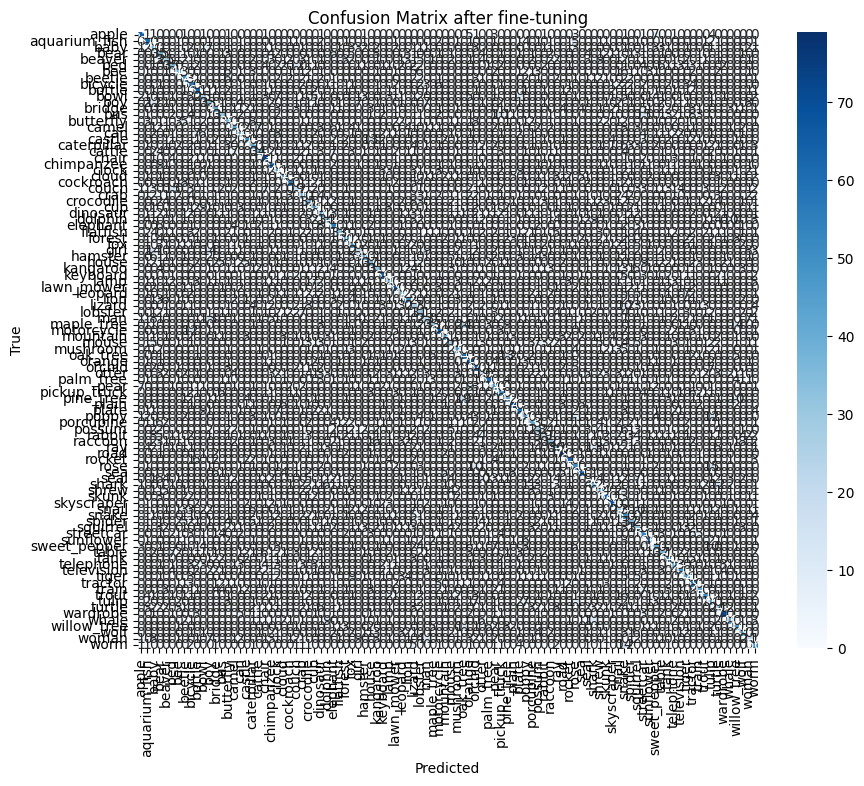

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Enhanced data augmentation for fine-tuning
transform_finetune = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
model.load_state_dict(torch.load('reworked_tiny_transformer_cifar100.pth'))

# Load CIFAR-100 dataset with enhanced augmentation for fine-tuning
trainset_finetune = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_finetune)
trainloader_finetune = torch.utils.data.DataLoader(trainset_finetune, batch_size=128, shuffle=True, num_workers=2)

# Same test set as before
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_finetune)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Model (assuming already defined as TinyTransformer)

# Adjust optimizer for fine-tuning
optimizer_finetune = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)

# Learning rate scheduler with cosine decay
scheduler_finetune = optim.lr_scheduler.CosineAnnealingLR(optimizer_finetune, T_max=200)

# Early stopping criteria
early_stopping_patience = 10
best_accuracy = 0.0
patience_counter = 0

# Fine-tuning function
def finetune(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs=100):
    global best_accuracy, patience_counter
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Early stopping logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'initial_fine_tuned_tiny_transformer_cifar100.pth')
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss / len(trainloader):.4f}, Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {accuracy:.2f}%")

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Fine-tuning the model
finetune(model, trainloader_finetune, testloader, criterion, optimizer_finetune, scheduler_finetune, device)

# Load the best fine-tuned model
model.load_state_dict(torch.load('initial_fine_tuned_tiny_transformer_cifar100.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy after fine-tuning: {accuracy:.4f}')

# Classification report
print("Classification Report after fine-tuning:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix after fine-tuning')
plt.show()


Test Accuracy after fine-tuning: 0.3992
Classification Report after fine-tuning:
               precision    recall  f1-score   support

        apple       0.65      0.52      0.58       500
aquarium_fish       0.57      0.47      0.52       500
         baby       0.48      0.29      0.36       500
         bear       0.30      0.34      0.32       500
       beaver       0.45      0.22      0.29       500
          bed       0.64      0.35      0.45       500
          bee       0.60      0.24      0.35       500
       beetle       0.30      0.45      0.36       500
      bicycle       0.50      0.42      0.45       500
       bottle       0.33      0.54      0.41       500
         bowl       0.49      0.12      0.19       500
          boy       0.31      0.42      0.36       500
       bridge       0.58      0.29      0.38       500
          bus       0.43      0.28      0.34       500
    butterfly       0.21      0.48      0.29       500
        camel       0.49      0.34    

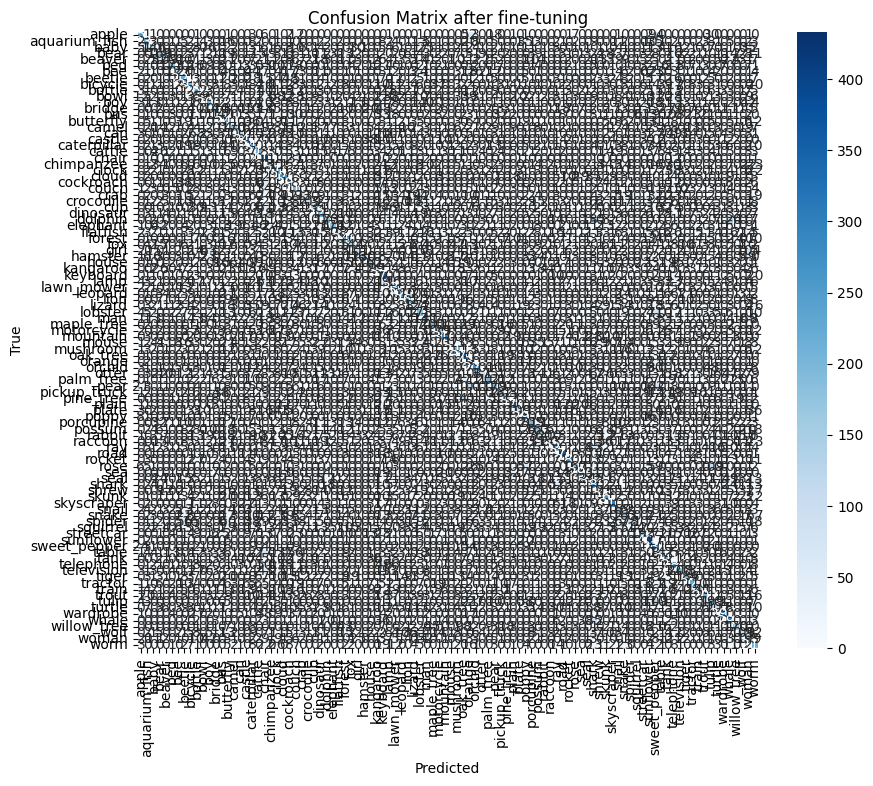

In [69]:
model.load_state_dict(torch.load('initial_fine_tuned_tiny_transformer_cifar100.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy after fine-tuning: {accuracy:.4f}')

# Classification report
print("Classification Report after fine-tuning:")
print(classification_report(all_labels, all_preds, target_names=trainset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix after fine-tuning')
plt.show()


2nd Fine tune

Optuna based finetuning

In [71]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:003.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.0/620.0 kB 12.1 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


Files already downloaded and verified
Files already downloaded and verified


[I 2024-07-14 20:38:17,399] A new study created in memory with name: no-name-c001e702-a112-41b0-80c9-98b9156ba8a1
/tmp/ipykernel_514921/3386391267.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
/tmp/ipykernel_514921/3386391267.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


Files already downloaded and verified
Files already downloaded and verified


Trial 0: 100%|██████████| 50/50 [32:22<00:00, 38.86s/it]
[I 2024-07-14 21:10:41,318] Trial 0 finished with value: 27.12 and parameters: {'lr': 0.00011432291812072809, 'weight_decay': 2.1335972962460035e-05, 'batch_size': 256}. Best is trial 0 with value: 27.12.


Files already downloaded and verified
Files already downloaded and verified


Trial 1: 100%|██████████| 50/50 [26:13<00:00, 31.47s/it]
[I 2024-07-14 21:36:55,865] Trial 1 finished with value: 37.34 and parameters: {'lr': 0.00017406711462446744, 'weight_decay': 0.0005441899099317463, 'batch_size': 128}. Best is trial 1 with value: 37.34.


Files already downloaded and verified
Files already downloaded and verified


Trial 2:  22%|██▏       | 11/50 [08:16<29:19, 45.12s/it]
[I 2024-07-14 21:45:13,152] Trial 2 finished with value: 38.36 and parameters: {'lr': 1.305860728305662e-05, 'weight_decay': 0.0006001027631604086, 'batch_size': 256}. Best is trial 2 with value: 38.36.


Files already downloaded and verified
Files already downloaded and verified


Trial 3:  28%|██▊       | 14/50 [09:44<25:02, 41.72s/it]
[I 2024-07-14 21:54:58,269] Trial 3 finished with value: 38.98 and parameters: {'lr': 4.783860673748959e-05, 'weight_decay': 1.8367181506358394e-05, 'batch_size': 256}. Best is trial 3 with value: 38.98.


Files already downloaded and verified
Files already downloaded and verified


Trial 4:  54%|█████▍    | 27/50 [09:12<07:50, 20.46s/it]
[I 2024-07-14 22:04:11,784] Trial 4 finished with value: 39.92 and parameters: {'lr': 3.140936438315865e-05, 'weight_decay': 1.312066479083235e-05, 'batch_size': 32}. Best is trial 4 with value: 39.92.


Files already downloaded and verified
Files already downloaded and verified


Trial 5:  36%|███▌      | 18/50 [09:35<17:02, 31.96s/it]
[I 2024-07-14 22:13:47,958] Trial 5 finished with value: 40.76 and parameters: {'lr': 5.172009103709338e-05, 'weight_decay': 1.7648461899018997e-05, 'batch_size': 128}. Best is trial 5 with value: 40.76.


Files already downloaded and verified
Files already downloaded and verified


Trial 6:  56%|█████▌    | 28/50 [19:04<14:59, 40.87s/it]
[I 2024-07-14 22:32:53,335] Trial 6 finished with value: 42.08 and parameters: {'lr': 4.2497036681726846e-05, 'weight_decay': 1.2029788436011036e-05, 'batch_size': 256}. Best is trial 6 with value: 42.08.


Files already downloaded and verified
Files already downloaded and verified


Trial 7: 100%|██████████| 50/50 [24:01<00:00, 28.84s/it]
[I 2024-07-14 22:56:56,112] Trial 7 finished with value: 47.16 and parameters: {'lr': 0.0008520587394104209, 'weight_decay': 0.0002259290035908121, 'batch_size': 64}. Best is trial 7 with value: 47.16.


Files already downloaded and verified
Files already downloaded and verified


Trial 8:  98%|█████████▊| 49/50 [27:30<00:33, 33.68s/it]
[I 2024-07-14 23:24:27,532] Trial 8 finished with value: 50.08 and parameters: {'lr': 0.0009565643596579288, 'weight_decay': 1.3413424051221751e-05, 'batch_size': 128}. Best is trial 8 with value: 50.08.


Files already downloaded and verified
Files already downloaded and verified


Trial 9:  42%|████▏     | 21/50 [10:20<14:17, 29.57s/it]
[I 2024-07-14 23:34:49,560] Trial 9 finished with value: 48.26 and parameters: {'lr': 0.0008985783440867253, 'weight_decay': 0.0006046163345838416, 'batch_size': 64}. Best is trial 8 with value: 50.08.


Files already downloaded and verified
Files already downloaded and verified


Trial 10:  32%|███▏      | 16/50 [09:08<19:25, 34.28s/it]
[I 2024-07-14 23:43:58,996] Trial 10 finished with value: 51.83 and parameters: {'lr': 0.00032249600700919354, 'weight_decay': 6.284409536812266e-05, 'batch_size': 128}. Best is trial 10 with value: 51.83.


Files already downloaded and verified
Files already downloaded and verified


Trial 11:  28%|██▊       | 14/50 [09:42<24:57, 41.60s/it]
[I 2024-07-14 23:53:42,318] Trial 11 finished with value: 51.65 and parameters: {'lr': 0.0002914160337166651, 'weight_decay': 4.999837357454512e-05, 'batch_size': 128}. Best is trial 10 with value: 51.83.


Files already downloaded and verified
Files already downloaded and verified


Trial 12:  24%|██▍       | 12/50 [14:19<45:22, 71.65s/it]
[I 2024-07-15 00:08:03,077] Trial 12 finished with value: 51.83 and parameters: {'lr': 0.000299312115127001, 'weight_decay': 7.44026258871189e-05, 'batch_size': 128}. Best is trial 10 with value: 51.83.


Files already downloaded and verified
Files already downloaded and verified


Trial 13:  76%|███████▌  | 38/50 [48:49<15:25, 77.09s/it]
[I 2024-07-15 00:56:53,470] Trial 13 finished with value: 52.15 and parameters: {'lr': 0.0003113249172179868, 'weight_decay': 7.33827461625891e-05, 'batch_size': 128}. Best is trial 13 with value: 52.15.


Files already downloaded and verified
Files already downloaded and verified


Trial 14:  42%|████▏     | 21/50 [15:26<21:19, 44.12s/it]
[I 2024-07-15 01:12:21,054] Trial 14 finished with value: 50.79 and parameters: {'lr': 0.00039824524356177966, 'weight_decay': 0.00018627631364618327, 'batch_size': 32}. Best is trial 13 with value: 52.15.


Files already downloaded and verified
Files already downloaded and verified


Trial 15:  28%|██▊       | 14/50 [20:06<51:43, 86.20s/it] 
[I 2024-07-15 01:32:28,810] Trial 15 finished with value: 51.79 and parameters: {'lr': 0.0004517473336684842, 'weight_decay': 3.601663141949592e-05, 'batch_size': 128}. Best is trial 13 with value: 52.15.


Files already downloaded and verified
Files already downloaded and verified


Trial 16:  42%|████▏     | 21/50 [24:02<33:11, 68.68s/it]
[I 2024-07-15 01:56:32,130] Trial 16 finished with value: 53.1 and parameters: {'lr': 0.00016819710717347835, 'weight_decay': 0.00012058599661061963, 'batch_size': 128}. Best is trial 16 with value: 53.1.


Files already downloaded and verified
Files already downloaded and verified


Trial 17:  52%|█████▏    | 26/50 [29:28<27:12, 68.03s/it]
[I 2024-07-15 02:26:02,010] Trial 17 finished with value: 53.0 and parameters: {'lr': 0.0001214616926254111, 'weight_decay': 0.0001428698827743143, 'batch_size': 128}. Best is trial 16 with value: 53.1.


Files already downloaded and verified
Files already downloaded and verified


Trial 18:  54%|█████▍    | 27/50 [18:12<15:30, 40.46s/it]
[I 2024-07-15 02:44:15,444] Trial 18 finished with value: 53.07 and parameters: {'lr': 9.660015107136186e-05, 'weight_decay': 0.00016966450237545402, 'batch_size': 64}. Best is trial 16 with value: 53.1.


Files already downloaded and verified
Files already downloaded and verified


Trial 19:  28%|██▊       | 14/50 [06:35<16:56, 28.25s/it]
[I 2024-07-15 02:50:51,924] Trial 19 finished with value: 52.91 and parameters: {'lr': 7.507856861197783e-05, 'weight_decay': 0.00032214714206966024, 'batch_size': 64}. Best is trial 16 with value: 53.1.


Files already downloaded and verified
Files already downloaded and verified


Trial 20:  22%|██▏       | 11/50 [10:52<38:34, 59.35s/it]
[I 2024-07-15 03:01:45,780] Trial 20 finished with value: 52.46 and parameters: {'lr': 0.0001762337942719348, 'weight_decay': 0.00012274112302307813, 'batch_size': 64}. Best is trial 16 with value: 53.1.


Files already downloaded and verified
Files already downloaded and verified


Trial 21:  54%|█████▍    | 27/50 [25:51<22:01, 57.47s/it]
[I 2024-07-15 03:27:38,398] Trial 21 finished with value: 53.3 and parameters: {'lr': 0.00012137056303143078, 'weight_decay': 0.0001222625684539768, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 22:  20%|██        | 10/50 [10:10<40:41, 61.03s/it]
[I 2024-07-15 03:37:49,713] Trial 22 finished with value: 52.81 and parameters: {'lr': 7.186932977353446e-05, 'weight_decay': 0.0003362991479053739, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 23:  24%|██▍       | 12/50 [12:03<38:11, 60.30s/it]
[I 2024-07-15 03:49:54,345] Trial 23 finished with value: 52.5 and parameters: {'lr': 0.00017769823942587057, 'weight_decay': 0.0001035821609071641, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 24:  32%|███▏      | 16/50 [19:01<40:25, 71.34s/it]
[I 2024-07-15 04:08:56,756] Trial 24 finished with value: 52.93 and parameters: {'lr': 2.3931222871733393e-05, 'weight_decay': 0.0002112538041233084, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 25:  50%|█████     | 25/50 [33:11<33:11, 79.66s/it] 
[I 2024-07-15 04:42:09,284] Trial 25 finished with value: 52.78 and parameters: {'lr': 7.900286352273417e-05, 'weight_decay': 0.0003050727942097394, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 26:  44%|████▍     | 22/50 [18:03<22:59, 49.27s/it]
[I 2024-07-15 05:00:14,103] Trial 26 finished with value: 52.7 and parameters: {'lr': 0.0001257695790598955, 'weight_decay': 0.00014191070543162346, 'batch_size': 32}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 27:  36%|███▌      | 18/50 [24:11<43:00, 80.64s/it] 
[I 2024-07-15 05:24:26,604] Trial 27 finished with value: 53.07 and parameters: {'lr': 0.00020048555360100068, 'weight_decay': 3.641838661303286e-05, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 28:  38%|███▊      | 19/50 [25:40<41:52, 81.06s/it] 
[I 2024-07-15 05:50:07,749] Trial 28 finished with value: 52.99 and parameters: {'lr': 8.860253417881432e-05, 'weight_decay': 9.596488972439781e-05, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 29:  28%|██▊       | 14/50 [11:51<30:28, 50.81s/it]
[I 2024-07-15 06:02:00,013] Trial 29 finished with value: 52.5 and parameters: {'lr': 0.00011791769699114206, 'weight_decay': 3.715344249975156e-05, 'batch_size': 32}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 30:  40%|████      | 20/50 [52:29<1:18:44, 157.49s/it]
[I 2024-07-15 06:54:30,770] Trial 30 finished with value: 52.54 and parameters: {'lr': 0.0005113226715791527, 'weight_decay': 0.0001731292594771687, 'batch_size': 256}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 31:  36%|███▌      | 18/50 [24:28<43:31, 81.60s/it] 
[I 2024-07-15 07:19:00,640] Trial 31 finished with value: 52.53 and parameters: {'lr': 0.00021232151424046723, 'weight_decay': 0.0009734864924819657, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 32:  38%|███▊      | 19/50 [25:35<41:45, 80.82s/it] 
[I 2024-07-15 07:44:37,278] Trial 32 finished with value: 52.54 and parameters: {'lr': 0.00023017480096772426, 'weight_decay': 2.791455220299055e-05, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 33:  34%|███▍      | 17/50 [23:11<45:00, 81.84s/it] 
[I 2024-07-15 08:07:49,613] Trial 33 finished with value: 52.7 and parameters: {'lr': 0.00014491742352973577, 'weight_decay': 5.252826735863817e-05, 'batch_size': 64}. Best is trial 21 with value: 53.3.


Files already downloaded and verified
Files already downloaded and verified


Trial 34:  52%|█████▏    | 26/50 [34:28<31:49, 79.54s/it] 
[I 2024-07-15 08:42:18,750] Trial 34 finished with value: 53.33 and parameters: {'lr': 0.00010198857367492725, 'weight_decay': 0.00011735296548223292, 'batch_size': 64}. Best is trial 34 with value: 53.33.


Files already downloaded and verified
Files already downloaded and verified


Trial 35:  26%|██▌       | 13/50 [17:52<50:52, 82.51s/it] 
[I 2024-07-15 09:00:12,360] Trial 35 finished with value: 53.34 and parameters: {'lr': 5.804208342603641e-05, 'weight_decay': 9.62637430847588e-05, 'batch_size': 64}. Best is trial 35 with value: 53.34.


Files already downloaded and verified
Files already downloaded and verified


Trial 36:  42%|████▏     | 21/50 [28:08<38:51, 80.41s/it] 
[I 2024-07-15 09:28:22,031] Trial 36 finished with value: 53.21 and parameters: {'lr': 5.6504120132505174e-05, 'weight_decay': 9.573830186518368e-05, 'batch_size': 64}. Best is trial 35 with value: 53.34.


Files already downloaded and verified
Files already downloaded and verified


Trial 37:  40%|████      | 20/50 [26:46<40:09, 80.33s/it] 
[I 2024-07-15 09:55:09,649] Trial 37 finished with value: 53.35 and parameters: {'lr': 2.087466728882442e-05, 'weight_decay': 8.88181584658069e-05, 'batch_size': 64}. Best is trial 37 with value: 53.35.


Files already downloaded and verified
Files already downloaded and verified


Trial 38:  30%|███       | 15/50 [20:35<48:02, 82.36s/it] 
[I 2024-07-15 10:15:46,108] Trial 38 finished with value: 53.27 and parameters: {'lr': 1.1017037299875389e-05, 'weight_decay': 8.376614321386242e-05, 'batch_size': 64}. Best is trial 37 with value: 53.35.


Files already downloaded and verified
Files already downloaded and verified


Trial 39:  40%|████      | 20/50 [52:27<1:18:41, 157.39s/it]
[I 2024-07-15 11:08:14,805] Trial 39 finished with value: 53.55 and parameters: {'lr': 1.6585581860786564e-05, 'weight_decay': 5.724034848161306e-05, 'batch_size': 256}. Best is trial 39 with value: 53.55.


Files already downloaded and verified
Files already downloaded and verified


Trial 40:  26%|██▌       | 13/50 [35:04<1:39:48, 161.85s/it]
[I 2024-07-15 11:43:19,836] Trial 40 finished with value: 53.72 and parameters: {'lr': 2.03455312671641e-05, 'weight_decay': 5.1796322233023864e-05, 'batch_size': 256}. Best is trial 40 with value: 53.72.


Files already downloaded and verified
Files already downloaded and verified


Trial 41:  42%|████▏     | 21/50 [55:09<1:16:10, 157.60s/it]
[I 2024-07-15 12:38:30,432] Trial 41 finished with value: 53.56 and parameters: {'lr': 1.8485310476242494e-05, 'weight_decay': 4.8334369969020204e-05, 'batch_size': 256}. Best is trial 40 with value: 53.72.


Files already downloaded and verified
Files already downloaded and verified


Trial 42:  40%|████      | 20/50 [52:26<1:18:39, 157.32s/it]
[I 2024-07-15 13:30:57,829] Trial 42 finished with value: 53.44 and parameters: {'lr': 1.9460286864975113e-05, 'weight_decay': 5.166295893100486e-05, 'batch_size': 256}. Best is trial 40 with value: 53.72.


Files already downloaded and verified
Files already downloaded and verified


Trial 43:  48%|████▊     | 24/50 [47:44<51:42, 119.34s/it]  
[I 2024-07-15 14:18:42,876] Trial 43 finished with value: 53.96 and parameters: {'lr': 2.0654211239570262e-05, 'weight_decay': 5.024596123446205e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 44:  44%|████▍     | 22/50 [21:00<26:44, 57.30s/it]
[I 2024-07-15 14:39:44,480] Trial 44 finished with value: 53.21 and parameters: {'lr': 1.5230043065603761e-05, 'weight_decay': 2.422929023299019e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 45:  36%|███▌      | 18/50 [17:22<30:52, 57.90s/it]
[I 2024-07-15 14:57:07,691] Trial 45 finished with value: 53.86 and parameters: {'lr': 3.532939326367168e-05, 'weight_decay': 5.482567886966402e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 46:  24%|██▍       | 12/50 [11:47<37:21, 58.98s/it]
[I 2024-07-15 15:08:56,445] Trial 46 finished with value: 53.44 and parameters: {'lr': 3.382611026443243e-05, 'weight_decay': 2.974803606968491e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 47:  38%|███▊      | 19/50 [18:18<29:51, 57.80s/it]
[I 2024-07-15 15:27:15,699] Trial 47 finished with value: 53.79 and parameters: {'lr': 1.5107517606022194e-05, 'weight_decay': 6.301332831256413e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 48:  32%|███▏      | 16/50 [15:30<32:56, 58.14s/it]
[I 2024-07-15 15:42:46,881] Trial 48 finished with value: 53.47 and parameters: {'lr': 2.950480910860526e-05, 'weight_decay': 4.310939142666381e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Files already downloaded and verified
Files already downloaded and verified


Trial 49:  20%|██        | 10/50 [10:07<40:28, 60.72s/it]
[I 2024-07-15 15:52:55,073] Trial 49 finished with value: 53.49 and parameters: {'lr': 1.1200299660453655e-05, 'weight_decay': 6.644893834988403e-05, 'batch_size': 256}. Best is trial 43 with value: 53.96.


Best trial: 53.96
Best hyperparameters: {'lr': 2.0654211239570262e-05, 'weight_decay': 5.024596123446205e-05, 'batch_size': 256}
Files already downloaded and verified
Files already downloaded and verified


  1%|          | 1/100 [00:54<1:30:06, 54.62s/it]

Epoch [1/100] - Train Loss: 1.0346, Test Loss: 2.0214, Test Accuracy: 52.25%


  2%|▏         | 2/100 [01:49<1:29:52, 55.02s/it]

Epoch [2/100] - Train Loss: 1.0256, Test Loss: 2.0070, Test Accuracy: 53.28%


  3%|▎         | 3/100 [02:45<1:29:30, 55.36s/it]

Epoch [3/100] - Train Loss: 1.0268, Test Loss: 2.0119, Test Accuracy: 53.13%


  4%|▍         | 4/100 [03:37<1:26:34, 54.11s/it]

Epoch [4/100] - Train Loss: 1.0327, Test Loss: 2.0019, Test Accuracy: 53.41%


  5%|▌         | 5/100 [04:29<1:24:15, 53.21s/it]

Epoch [5/100] - Train Loss: 1.0362, Test Loss: 2.0357, Test Accuracy: 52.61%


  6%|▌         | 6/100 [05:24<1:24:28, 53.92s/it]

Epoch [6/100] - Train Loss: 1.0252, Test Loss: 2.0323, Test Accuracy: 52.60%


  7%|▋         | 7/100 [06:22<1:25:14, 55.00s/it]

Epoch [7/100] - Train Loss: 1.0370, Test Loss: 2.0214, Test Accuracy: 52.62%


  8%|▊         | 8/100 [07:18<1:24:51, 55.34s/it]

Epoch [8/100] - Train Loss: 1.0265, Test Loss: 2.0182, Test Accuracy: 52.84%


  9%|▉         | 9/100 [08:13<1:24:04, 55.43s/it]

Epoch [9/100] - Train Loss: 1.0263, Test Loss: 2.0140, Test Accuracy: 53.36%


 10%|█         | 10/100 [09:08<1:22:56, 55.29s/it]

Epoch [10/100] - Train Loss: 1.0282, Test Loss: 2.0128, Test Accuracy: 52.75%


 11%|█         | 11/100 [10:04<1:22:07, 55.37s/it]

Epoch [11/100] - Train Loss: 1.0295, Test Loss: 2.0410, Test Accuracy: 52.93%


 12%|█▏        | 12/100 [10:55<1:19:33, 54.25s/it]

Epoch [12/100] - Train Loss: 1.0302, Test Loss: 2.0147, Test Accuracy: 52.74%


 13%|█▎        | 13/100 [11:50<1:18:37, 54.22s/it]

Epoch [13/100] - Train Loss: 1.0375, Test Loss: 2.0238, Test Accuracy: 52.54%


 13%|█▎        | 13/100 [12:46<1:25:31, 58.98s/it]

Epoch [14/100] - Train Loss: 1.0337, Test Loss: 2.0356, Test Accuracy: 52.61%
Early stopping triggered


Test Accuracy after fine-tuning with Optuna: 0.5253
Classification Report after fine-tuning with Optuna:
               precision    recall  f1-score   support

        apple       0.69      0.75      0.72       100
aquarium_fish       0.66      0.59      0.62       100
         baby       0.48      0.41      0.44       100
         bear       0.40      0.38      0.39       100
       beaver       0.37      0.33      0.35       100
          bed       0.45      0.42      0.44       100
          bee       0.53      0.54      0.53       100
       beetle       0.48      0.48      0.48       100
      bicycle       0.65      0.62      0.64       100
       bottle       0.65      0.66      0.66       100
         bowl       0.34      0.34      0.34       100
          boy       0.40      0.33      0.36       100
       bridge       0.57      0.56      0.57       100
          bus       0.49      0.46      0.47       100
    butterfly       0.49      0.39      0.44       100
        camel 

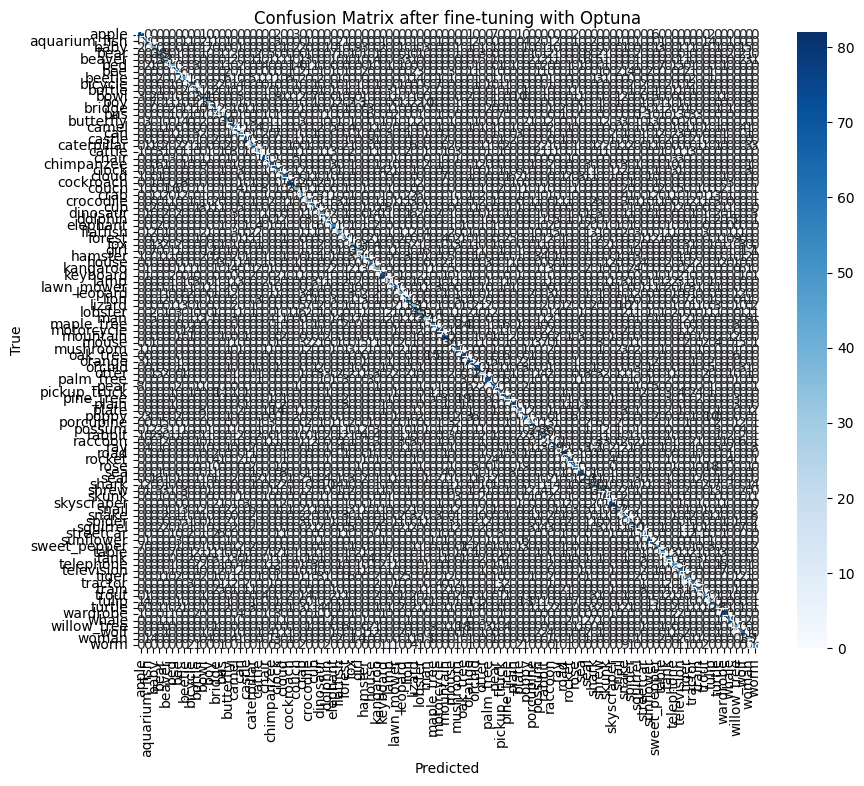

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import optuna
from optuna.trial import TrialState
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load CIFAR-100 dataset
def get_data_loaders(transform, batch_size):
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainloader, testloader

# Enhanced data augmentation for fine-tuning
transform_finetune = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Original CIFAR-100 normalization values
])

trainloader_finetune, testloader = get_data_loaders(transform_finetune, batch_size=128)

# Define the model, assuming TinyTransformer is already defined
model = TinyTransformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])

    trainloader_finetune, testloader = get_data_loaders(transform_finetune, batch_size)

    optimizer_finetune = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler_finetune = optim.lr_scheduler.CosineAnnealingLR(optimizer_finetune, T_max=100)

    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0.0
    patience_counter = 0
    early_stopping_patience = 10

    for epoch in tqdm(range(50),desc=f"Trial {trial.number}"):  # Use fewer epochs for faster tuning
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader_finetune:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_finetune.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_finetune.step()
            running_loss += loss.item()

        scheduler_finetune.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Early stopping logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            break

    return best_accuracy

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

# Use the best hyperparameters to fine-tune the model
best_params = study.best_trial.params
trainloader_finetune, testloader = get_data_loaders(transform_finetune, batch_size=best_params['batch_size'])

optimizer_finetune = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler_finetune = optim.lr_scheduler.CosineAnnealingLR(optimizer_finetune, T_max=100)

# Fine-tune with the best hyperparameters
def finetune(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs=100):
    best_accuracy = 0.0
    patience_counter = 0
    early_stopping_patience = 10

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Early stopping logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'optuna_fine_tuned_best_model.pth')
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss / len(trainloader):.4f}, Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {accuracy:.2f}%")

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

criterion = nn.CrossEntropyLoss()
finetune(model, trainloader_finetune, testloader, criterion, optimizer_finetune, scheduler_finetune, device)

# Load the best fine-tuned model
model.load_state_dict(torch.load('optuna_fine_tuned_best_model.pth'))

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy after fine-tuning with Optuna: {accuracy:.4f}')

# Classification report
print("Classification Report after fine-tuning with Optuna:")
print(classification_report(all_labels, all_preds, target_names=trainset_finetune.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset_finetune.classes, yticklabels=trainset_finetune.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix after fine-tuning with Optuna')
plt.show()


Best hyperparameters: {'lr': 2.0654211239570262e-05, 'weight_decay': 5.024596123446205e-05, 'batch_size': 256}


Efficient former

In [74]:
!pip install torch torchvision transformers datasets



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [84]:
from transformers import AutoImageProcessor, EfficientFormerForImageClassification
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientFormer expects 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))  # Normalize images
])

train_dataset = CIFAR100(root="./data", train=True, download=True, transform=transform)
test_dataset = CIFAR100(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [85]:
image_processor = AutoImageProcessor.from_pretrained("snap-research/efficientformer-l1-300")
model = EfficientFormerForImageClassification.from_pretrained("snap-research/efficientformer-l1-300")

# Adjust the model for CIFAR-100 (100 classes)
model.classifier = torch.nn.Linear(model.classifier.in_features, 100)


In [79]:
#{'lr': 2.0654211239570262e-05, 'weight_decay': 5.024596123446205e-05, 'batch_size': 256}
from torch.optim import AdamW
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from transformers import get_cosine_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2.0654211239570262e-05, weight_decay=5.024596123446205e-05)
criterion = CrossEntropyLoss()

num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)

model.train()
save_path = "efficient_former_best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}%")
    
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with accuracy: {best_accuracy}%")



Epoch 1/10: 100%|██████████| 1563/1563 [7:53:08<00:00, 18.16s/it]      


Epoch 1/10, Loss: 3.440112893884943, Accuracy: 54.77%
Best model saved with accuracy: 54.77%


Epoch 2/10: 100%|██████████| 1563/1563 [1:33:03<00:00,  3.57s/it]   


Epoch 2/10, Loss: 1.3254163606915808, Accuracy: 67.91%
Best model saved with accuracy: 67.91%


Epoch 3/10: 100%|██████████| 1563/1563 [1:46:30<00:00,  4.09s/it]


Epoch 3/10, Loss: 0.9284512894853749, Accuracy: 73.02%
Best model saved with accuracy: 73.02%


Epoch 4/10: 100%|██████████| 1563/1563 [2:07:31<00:00,  4.90s/it] 


Epoch 4/10, Loss: 0.7393831363089636, Accuracy: 75.53%
Best model saved with accuracy: 75.53%


Epoch 5/10: 100%|██████████| 1563/1563 [1:07:46<00:00,  2.60s/it]


Epoch 5/10, Loss: 0.6262736454157972, Accuracy: 76.67%
Best model saved with accuracy: 76.67%


Epoch 6/10: 100%|██████████| 1563/1563 [1:07:54<00:00,  2.61s/it]


Epoch 6/10, Loss: 0.5493389675042145, Accuracy: 77.2%
Best model saved with accuracy: 77.2%


Epoch 7/10: 100%|██████████| 1563/1563 [1:08:00<00:00,  2.61s/it]


Epoch 7/10, Loss: 0.4972930725137164, Accuracy: 77.78%
Best model saved with accuracy: 77.78%


Epoch 8/10: 100%|██████████| 1563/1563 [48:28<00:00,  1.86s/it] 


Epoch 8/10, Loss: 0.46468946556021445, Accuracy: 78.05%
Best model saved with accuracy: 78.05%


Epoch 9/10: 100%|██████████| 1563/1563 [38:09<00:00,  1.46s/it]


Epoch 9/10, Loss: 0.4480280665560403, Accuracy: 78.13%
Best model saved with accuracy: 78.13%


Epoch 10/10: 100%|██████████| 1563/1563 [38:09<00:00,  1.46s/it]


Epoch 10/10, Loss: 0.43984135413829595, Accuracy: 78.09%
